In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

from mechir.data import CatDataCollator, DotDataCollator, MechDataset

def process_frame(frame):

    output = {
        'qid': [],
        'query': [],
        'docno': [],
        'text': [],
        'perturbed': [],
    }

    for row in frame.itertuples():
        output['qid'].append(row.qid)
        output['query'].append(row.query)
        output['docno'].append(row.docno)
        output['text'].append(row.text)
        output['perturbed'].append(row.perturbed_text)
    
    return pd.DataFrame(output)

Matplotlib created a temporary cache directory at /tmp/matplotlib-nv989sjn because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories


In [2]:
FORMATTED_MODEL_NAME = 'sentence-transformers-msmarco-distilbert-cos-v5'
MODEL_TYPE = 'bi'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 20

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_head.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('patch_head', 'original_scores'))
perturbed_scores = np.load(data_path.replace('patch_head', 'perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')

In [31]:
score_difference = perturbed_scores - original_scores

patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))

patching_results_normalised_logarithm = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.log(1 + np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
mean_magnitude = np.mean(np.abs(patching_results_normalised), axis=(-2,-1))
mean_magnitude_logarithm = np.mean(np.abs(patching_results_normalised_logarithm), axis=(-2,-1))
mean_magnitude_square = np.mean(np.abs(patching_results_normalised_square), axis=(-2,-1))
mean_magnitude_unnormalised = np.mean(np.abs(patching_results - original_scores[:, np.newaxis, np.newaxis]), axis=(-2,-1))
mean_relative_magnitude = np.mean(patching_results_normalised, axis=(-2,-1))
mean_relative_magnitude_unnormalised = np.mean(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-2,-1))
max_relative_magnitude_unnormalised = np.max(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-2,-1))
sorted_magnitudes = np.argsort(mean_magnitude)[::-1]
patching_results_normalised_sorted = patching_results_normalised[sorted_magnitudes]

all_data_pd['score_difference_when_patching'] = score_difference
all_data_pd['mean_magnitude'] = mean_magnitude
all_data_pd['mean_magnitude_unnormalised'] = mean_magnitude_unnormalised
all_data_pd['mean_relative_magnitude'] = mean_relative_magnitude
all_data_pd['mean_relative_magnitude_unnormalised'] = mean_relative_magnitude_unnormalised
all_data_pd['max_relative_magnitude_unnormalised'] = max_relative_magnitude_unnormalised

In [4]:
def micro_mean(patching_results, original_scores, perturbed_scores, range=[0,1000]):
    return ((patching_results[range[0]:range[1]] - original_scores[range[0]:range[1]][:, np.newaxis, np.newaxis]) / 
            np.abs((perturbed_scores[range[0]:range[1]][:, np.newaxis, np.newaxis] - original_scores[range[0]:range[1]][:, np.newaxis, np.newaxis]))).mean(axis=0)

def macro_mean(patching_results, original_scores, perturbed_scores, range=[0,1000]):
    return ((patching_results[range[0]:range[1]].mean(axis=0) - original_scores[range[0]:range[1]][:, np.newaxis, np.newaxis].mean(axis=0)) / 
            (perturbed_scores[range[0]:range[1]][:, np.newaxis, np.newaxis].mean(axis=0) - original_scores[range[0]:range[1]][:, np.newaxis, np.newaxis].mean(axis=0)))

<Axes: >

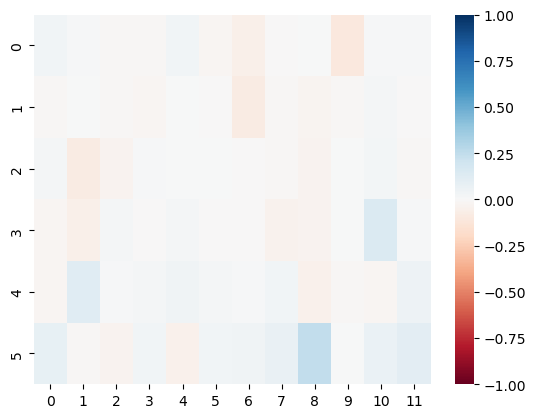

In [7]:
sns.heatmap(
    np.mean(patching_results_normalised, axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

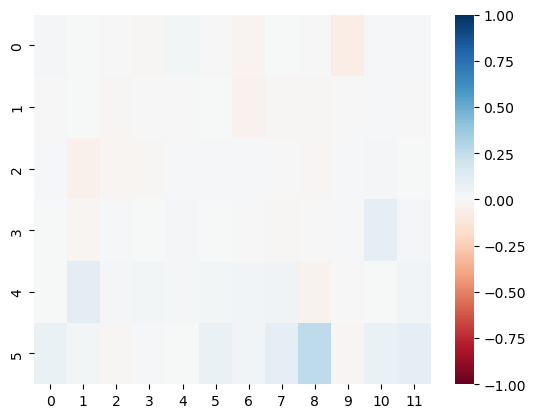

In [38]:
sns.heatmap(
    np.mean(patching_results_normalised[score_difference > 0], axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

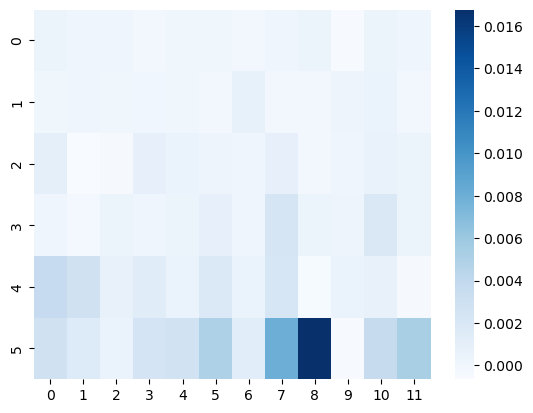

In [40]:
sns.heatmap(
    np.mean(patching_results_normalised_square, axis=0),
    # vmax=1,
    # vmin=-1,
    cmap='Blues'
)

<Axes: >

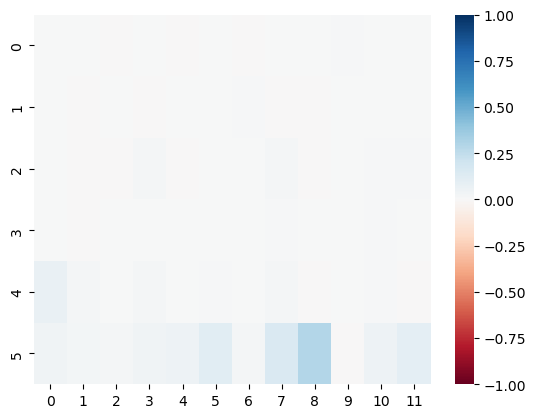

In [28]:
sns.heatmap(
    np.mean(patching_results_normalised[score_difference > 0.4], axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

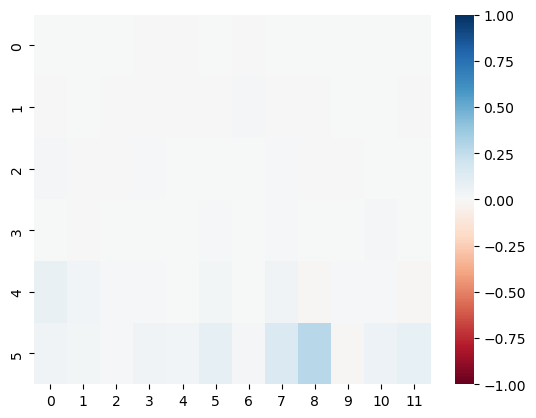

In [9]:
sns.heatmap(
        micro_mean(patching_results, original_scores, perturbed_scores, range=[0,1000]),
        vmax=1,
        vmin=-1,
        cmap='RdBu',)

Let's once again analyse correlation between some properties and mean absolute patching effect

In [10]:
pearsonr(mean_magnitude, perturbed_scores - original_scores)

PearsonRResult(statistic=-0.09435624060735223, pvalue=2.2438673978326843e-09)

In [11]:
spearmanr(mean_magnitude, perturbed_scores - original_scores)

SignificanceResult(statistic=-0.8527556070181773, pvalue=0.0)

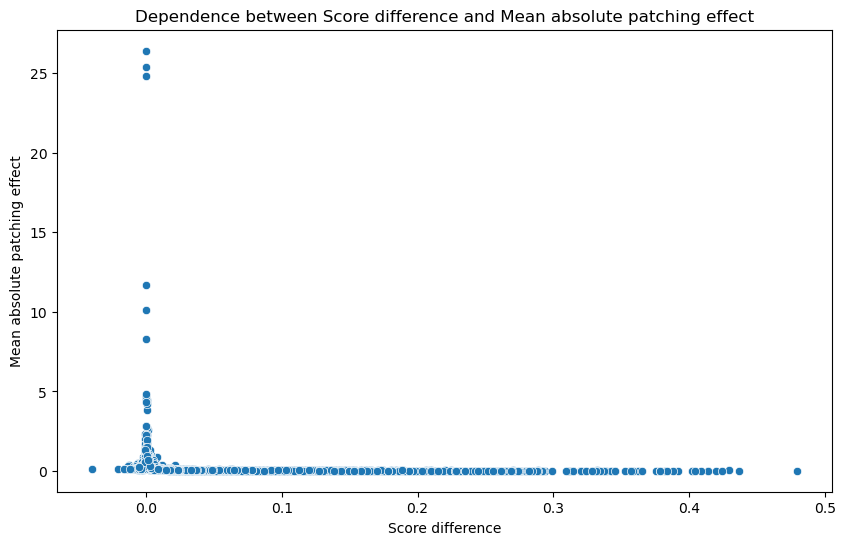

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()

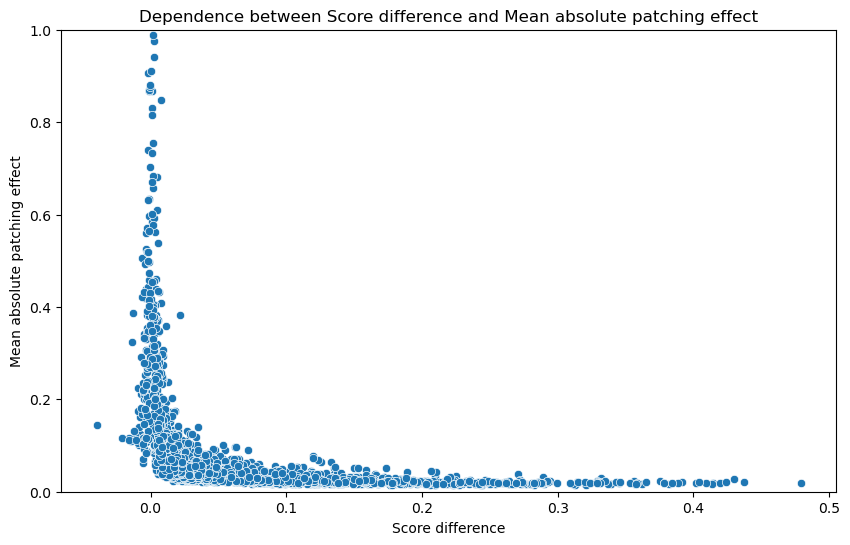

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude)
plt.ylim(0,1)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()

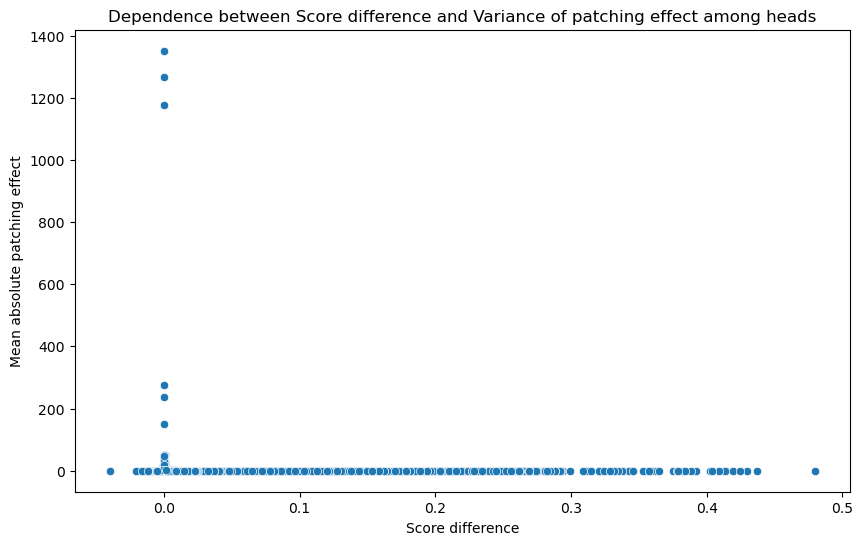

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=variance)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute patching effect')
plt.title(f'Dependence between Score difference and Variance of patching effect among heads')
plt.show()

Let's test how does the difference between the patched score and original score depends on the difference between the perturbed score and original score

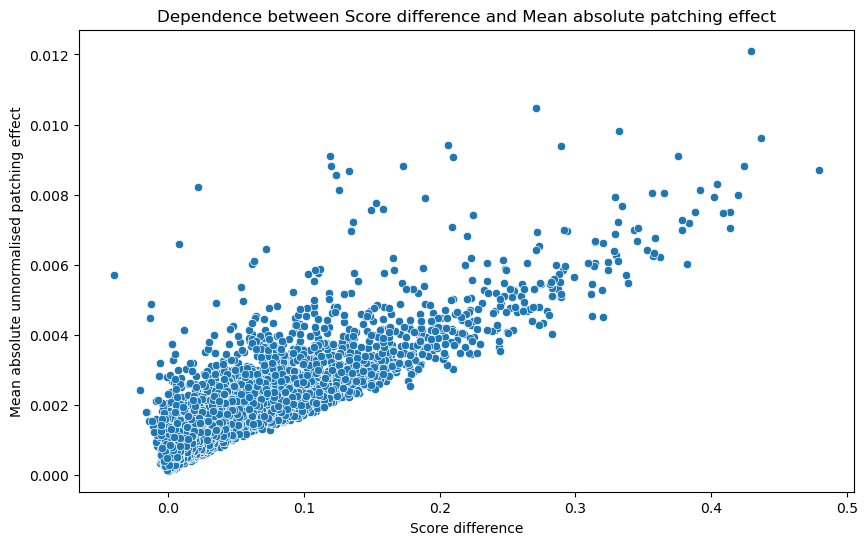

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_magnitude_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Mean absolute unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean absolute patching effect')
plt.show()

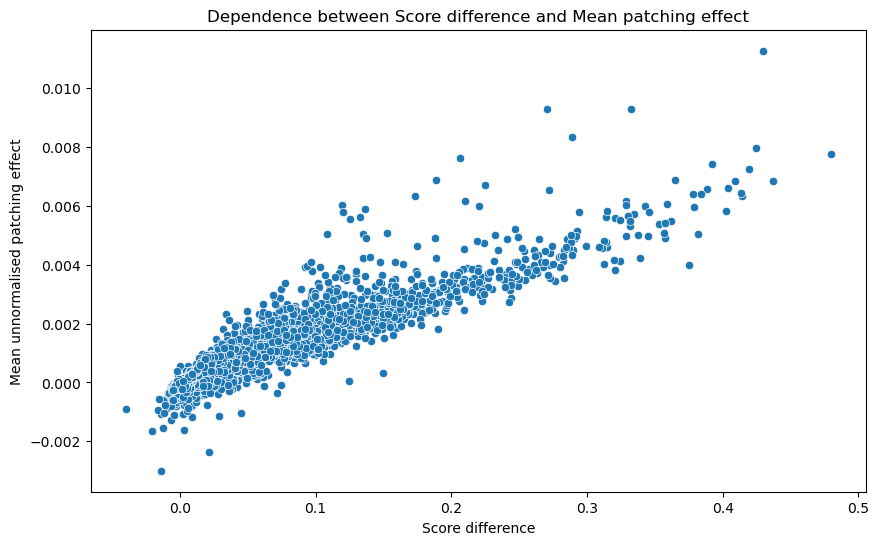

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=mean_relative_magnitude_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

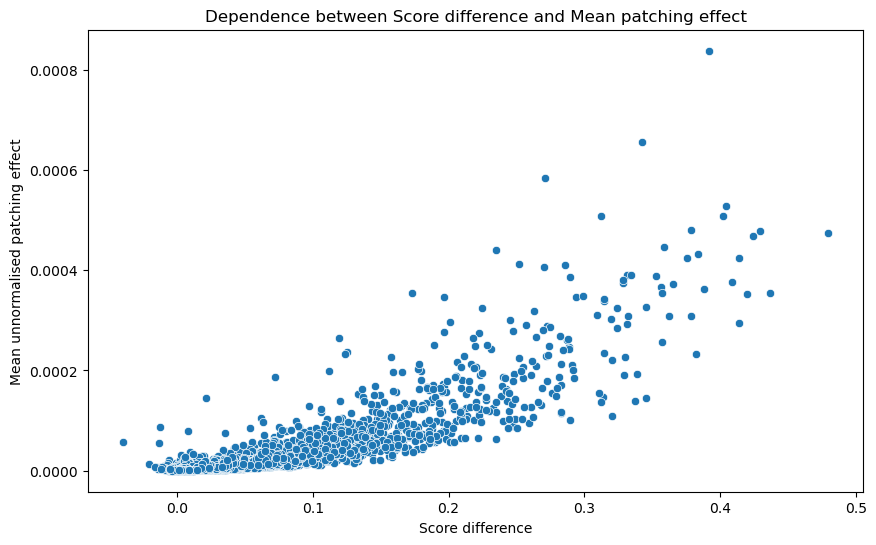

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=variance_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

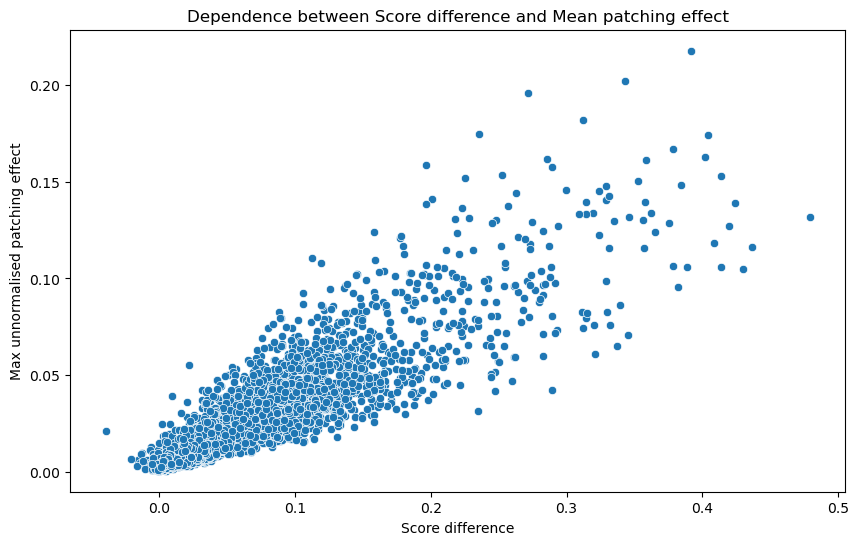

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=perturbed_scores - original_scores, y=max_relative_magnitude_unnormalised)
plt.xlabel('Score difference')
plt.ylabel('Max unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

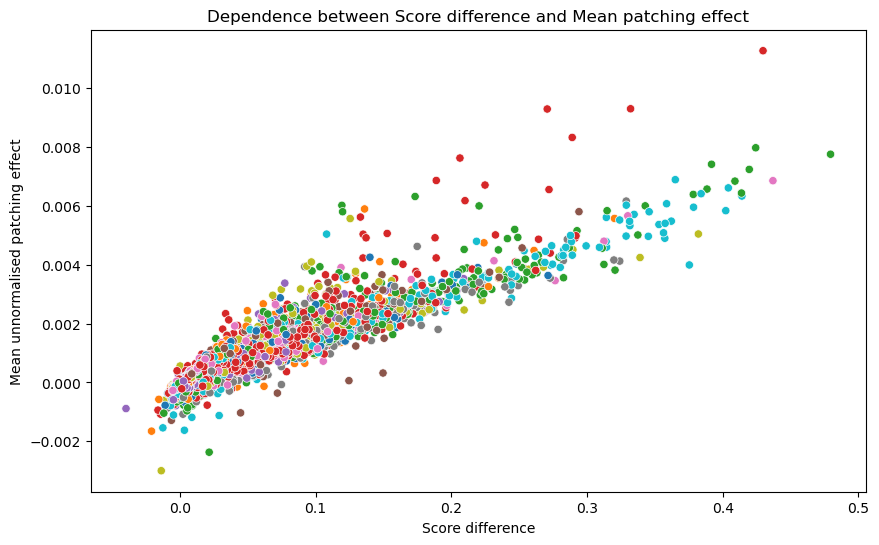

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='mean_relative_magnitude_unnormalised', hue='qid', palette='tab10', legend=False)
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

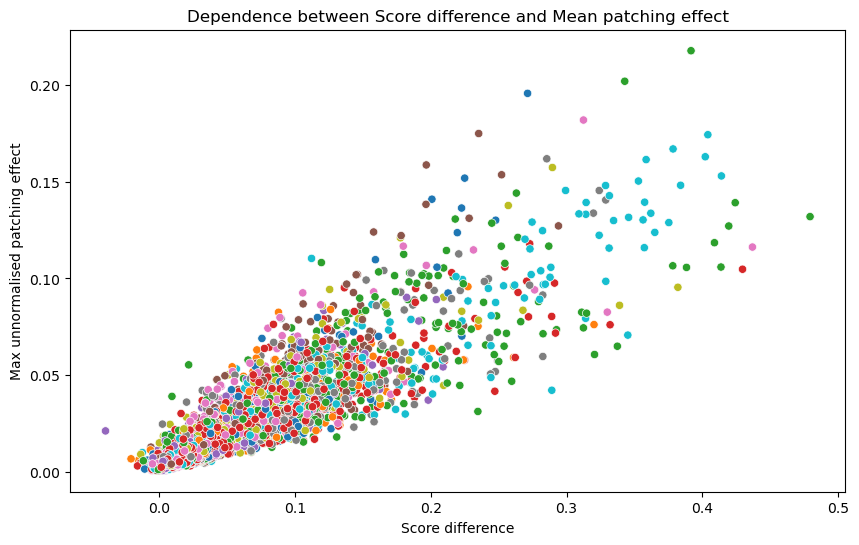

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='max_relative_magnitude_unnormalised', hue='qid', palette='tab10', legend=False)
plt.xlabel('Score difference')
plt.ylabel('Max unnormalised patching effect')
plt.title(f'Dependence between Score difference and Mean patching effect')
plt.show()

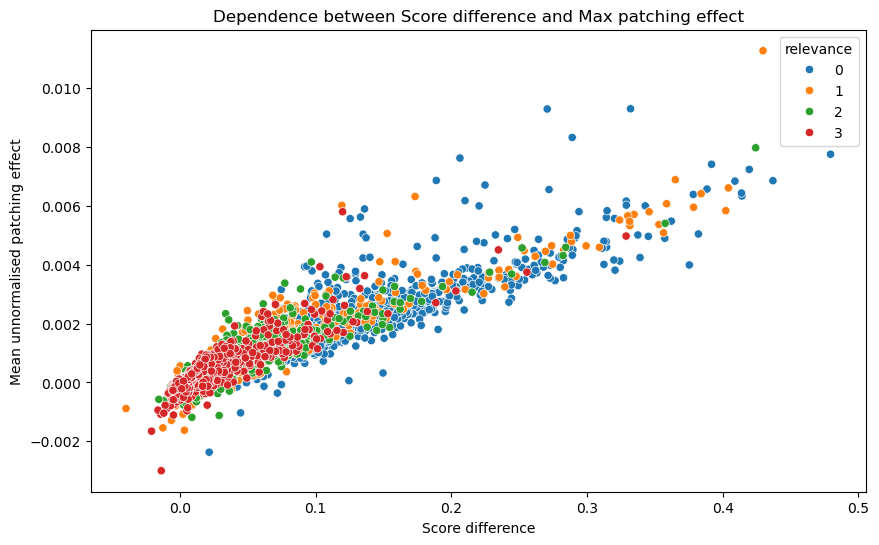

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='mean_relative_magnitude_unnormalised', hue='relevance', palette='tab10')
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Max patching effect')
plt.show()

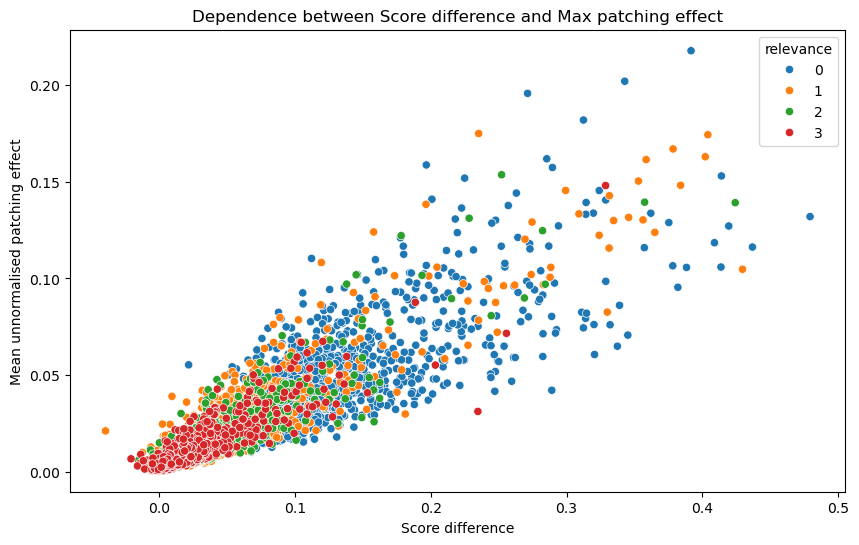

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_data_pd, x='score_difference_when_patching', y='max_relative_magnitude_unnormalised', hue='relevance', palette='tab10')
plt.xlabel('Score difference')
plt.ylabel('Mean unnormalised patching effect')
plt.title(f'Dependence between Score difference and Max patching effect')
plt.show()